# Set-Up Environment

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd

# Load in the Dataset and look at it

In [2]:
data = pd.read_csv('Dec_Users.csv')
print(data.shape)
data.head()

(3194346, 3)


,registered_user_id,stream_requests,stream_playing_time_combined
0,204e1465-4a3b-4fe4-9a33-741e67120cae,1,1.180
1,e86b7599-fc07-49a7-a56d-f2dd8299585b,7,8178.172
2,9f8f102a-d5a5-4f3a-8dde-5575e0cbe3f9,61,59304.408
3,bd443f09-4fe0-42a8-88c2-5447f009f3df,16,18512.761
4,e0375d89-d0dc-404a-aab4-4b50e20e35b5,5,6598.268


# Remove Outliers in the data

In [3]:
data2 = data.loc[data.stream_requests.values< 600, ['stream_requests', 'stream_playing_time_combined']]
data2 = data2.loc[data2.stream_playing_time_combined.values>0]
data2 = data2.loc[data2.stream_playing_time_combined.values<360000]
data2.head()

,stream_requests,stream_playing_time_combined
0,1,1.180
1,7,8178.172
2,61,59304.408
3,16,18512.761
4,5,6598.268


# Scale the data to stop one variable having disproportionate weighting in the clustering

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(data2))

StandardScaler(copy=True, with_mean=True, with_std=True)


In [5]:
print(scaler.transform(data2))

[[-0.54108856 -0.56209034]
 [-0.19588275 -0.23964284]
 [ 2.91096953  1.77644412]
 ..., 
 [-0.42601996 -0.0807409 ]
 [-0.54108856  0.28962652]
 [-0.54108856 -0.51556329]]


# Plot the standardised data

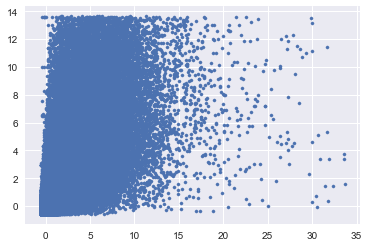

In [6]:
x = scaler.transform(data2)
plt.scatter(x[:,0],x[:,1], s=10);

# Use the K-means algorithm to cluster the scaled data

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(x)
y_kmeans = kmeans.predict(x)

# Plot the clusters with their centres

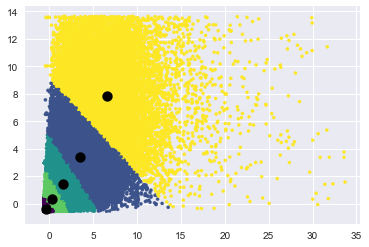

In [8]:
plt.scatter(x[:,0], x[:,1], c=y_kmeans, s=10, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100)

In [9]:
y_kmeans

array([0, 0, 2, ..., 0, 0, 0])

# Append two columns to the dataframe, one containing the cluster number and user_id

In [10]:
data2['Cluster'] = y_kmeans
data2['id']=data.registered_user_id
data2.head()

,stream_requests,stream_playing_time_combined,Cluster,id
0,1,1.180,0,204e1465-4a3b-4fe4-9a33-741e67120cae
1,7,8178.172,0,e86b7599-fc07-49a7-a56d-f2dd8299585b
2,61,59304.408,2,9f8f102a-d5a5-4f3a-8dde-5575e0cbe3f9
3,16,18512.761,3,bd443f09-4fe0-42a8-88c2-5447f009f3df
4,5,6598.268,0,e0375d89-d0dc-404a-aab4-4b50e20e35b5


# Calculate the size of each cluster in terms of the number of IDs

In [1]:
cluster_sizes = pd.DataFrame=data2.groupby('Cluster').id.nunique().reset_index()
cluster_sizes.head()

NameError: name 'data2' is not defined

# Calculate the sum of Requests / Consumption for each cluster

In [12]:
data2.groupby('Cluster').stream_requests.sum()

Cluster
0    7547818
1    5187565
2    8513615
3    9377301
4    2069061
Name: stream_requests, dtype: int64

In [13]:
data2.groupby('Cluster').stream_playing_time_combined.sum()

Cluster
0    9.658211e+09
1    7.266062e+09
2    1.124619e+10
3    1.309161e+10
4    3.533616e+09
Name: stream_playing_time_combined, dtype: float64

# Find the minimum / maximum value for Requests / Consumption for each cluster

In [14]:
data2.groupby('Cluster').stream_requests.max()

Cluster
0     18
1    246
2    102
3     47
4    596
Name: stream_requests, dtype: int64

In [15]:
data2.groupby('Cluster').stream_playing_time_combined.max()

Cluster
0     26496.147
1    236377.273
2    140407.260
3     74004.114
4    359982.721
Name: stream_playing_time_combined, dtype: float64

# Plot the original unscaled data with their clusters

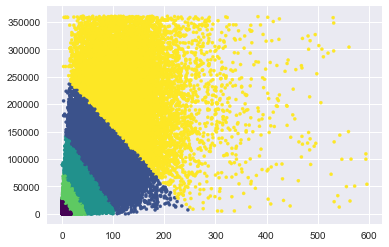

In [16]:
plt.scatter(data2['stream_requests'], data2['stream_playing_time_combined'], c=y_kmeans, s=10, cmap='viridis')

In [17]:
import hdbscan

data2 = data2.loc[:,['stream_requests','stream_playing_time_combined']]
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(data2)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

In [20]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data2.T[0], data2.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

In [23]:
import hdbscan
plot_clusters(data2, hdbscan.HDBSCAN, (), {'min_cluster_size':10000})

JoblibMemoryError: JoblibMemoryError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x0000000002A35C90, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\ryanwala\AppData\Local\Continuum\anacon...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\r...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000000002A35C90, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\ryanwala\AppData\Local\Continuum\anacon...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\r...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "import hdbscan\nplot_clusters(data2, hdbscan.HDBSCAN, (), {'min_cluster_size':1000})", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 27, 11, 37, 20, 426218, tzinfo=tzutc()), 'msg_id': '6D541537BB8D4243A2131D1F127610BC', 'msg_type': 'execute_request', 'session': 'E003F5F8F27D45408151C8EBA12A78CC', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '6D541537BB8D4243A2131D1F127610BC', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'E003F5F8F27D45408151C8EBA12A78CC']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "import hdbscan\nplot_clusters(data2, hdbscan.HDBSCAN, (), {'min_cluster_size':1000})", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 27, 11, 37, 20, 426218, tzinfo=tzutc()), 'msg_id': '6D541537BB8D4243A2131D1F127610BC', 'msg_type': 'execute_request', 'session': 'E003F5F8F27D45408151C8EBA12A78CC', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '6D541537BB8D4243A2131D1F127610BC', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'E003F5F8F27D45408151C8EBA12A78CC'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "import hdbscan\nplot_clusters(data2, hdbscan.HDBSCAN, (), {'min_cluster_size':1000})", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 27, 11, 37, 20, 426218, tzinfo=tzutc()), 'msg_id': '6D541537BB8D4243A2131D1F127610BC', 'msg_type': 'execute_request', 'session': 'E003F5F8F27D45408151C8EBA12A78CC', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '6D541537BB8D4243A2131D1F127610BC', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="import hdbscan\nplot_clusters(data2, hdbscan.HDBSCAN, (), {'min_cluster_size':1000})", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "import hdbscan\nplot_clusters(data2, hdbscan.HDBSCAN, (), {'min_cluster_size':1000})"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("import hdbscan\nplot_clusters(data2, hdbscan.HDBSCAN, (), {'min_cluster_size':1000})",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("import hdbscan\nplot_clusters(data2, hdbscan.HDBSCAN, (), {'min_cluster_size':1000})",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="import hdbscan\nplot_clusters(data2, hdbscan.HDBSCAN, (), {'min_cluster_size':1000})", store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Import object>, <_ast.Expr object>], cell_name='<ipython-input-23-95bbb57b71dc>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at f79a208, execution_co..._before_exec=None error_in_exec=None result=None>)
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])
   2807                 code = compiler(mod, cell_name, "single")
-> 2808                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000000095263540, file "<ipython-input-23-95bbb57b71dc>", line 2>
        result = <ExecutionResult object at f79a208, execution_co..._before_exec=None error_in_exec=None result=None>
   2809                     return True
   2810 
   2811             # Flush softspace
   2812             if softspace(sys.stdout, 0):

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000000095263540, file "<ipython-input-23-95bbb57b71dc>", line 2>, result=<ExecutionResult object at f79a208, execution_co..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000000095263540, file "<ipython-input-23-95bbb57b71dc>", line 2>
        self.user_global_ns = {'In': ['', "get_ipython().magic('matplotlib inline')\nimport ...ot styling\nimport numpy as np\nimport pandas as pd", "data = pd.read_csv('Dec_Users.csv')\nprint(data.shape)\ndata.head()", 'data2 = data.loc[data.stream_requests.values< 60...playing_time_combined.values<360000]\ndata2.head()', 'from sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\nprint(scaler.fit(data2))', 'print(scaler.transform(data2))', 'x = scaler.transform(data2)\nplt.scatter(x[:,0],x[:,1], s=10);', 'from sklearn.cluster import KMeans\nkmeans = KMea...ers=5)\nkmeans.fit(x)\ny_kmeans = kmeans.predict(x)', "plt.scatter(x[:,0], x[:,1], c=y_kmeans, s=10, cm...r(centers[:, 0], centers[:, 1], c='black', s=100)", 'y_kmeans', "data2['Cluster'] = y_kmeans\ndata2['id']=data.registered_user_id\ndata2.head()", "cluster_sizes = pd.DataFrame=data2.groupby('Clus...).id.nunique().reset_index()\ncluster_sizes.head()", "data2.groupby('Cluster').stream_requests.sum()", "data2.groupby('Cluster').stream_playing_time_combined.sum()", "data2.groupby('Cluster').stream_requests.max()", "data2.groupby('Cluster').stream_playing_time_combined.max()", "plt.scatter(data2['stream_requests'], data2['str...ime_combined'], c=y_kmeans, s=10, cmap='viridis')", "import hdbscan\n\ndata2 = data2.loc[:,['stream_req...e=5, gen_min_span_tree=True)\nclusterer.fit(data2)", 'palette = sns.color_palette()\ncluster_colors = [...ata2[0], data2[1], c=cluster_colors, **plot_kwds)', "import numpy as np\nimport matplotlib.pyplot as p...kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}", ...], 'KMeans': <class 'sklearn.cluster.k_means_.KMeans'>, 'Out': {2:                      registered_user_id  stream_...    18512.761  
4                      6598.268  , 3:    stream_requests  stream_playing_time_combined...
4                5                      6598.268, 8: <matplotlib.collections.PathCollection object>, 9: array([0, 0, 2, ..., 0, 0, 0]), 10:    stream_requests  stream_playing_time_combined...9f3df  
4  e0375d89-d0dc-404a-aab4-4b50e20e35b5  , 11:    Cluster       id
0        0  2247922
1       ...   227153
3        3   578214
4        4    16566, 12: Cluster
0    7547818
1    5187565
2    8513615
3...
4    2069061
Name: stream_requests, dtype: int64, 13: Cluster
0    9.658211e+09
1    7.266062e+09
2   ...ame: stream_playing_time_combined, dtype: float64, 14: Cluster
0     18
1    246
2    102
3     47
4    596
Name: stream_requests, dtype: int64, 15: Cluster
0     26496.147
1    236377.273
2    140...ame: stream_playing_time_combined, dtype: float64, ...}, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, '_': HDBSCAN(algorithm='best', allow_single_cluster=F..._samples=None, p=None,
    prediction_data=False), '_10':    stream_requests  stream_playing_time_combined...9f3df  
4  e0375d89-d0dc-404a-aab4-4b50e20e35b5  , '_11':    Cluster       id
0        0  2247922
1       ...   227153
3        3   578214
4        4    16566, '_12': Cluster
0    7547818
1    5187565
2    8513615
3...
4    2069061
Name: stream_requests, dtype: int64, '_13': Cluster
0    9.658211e+09
1    7.266062e+09
2   ...ame: stream_playing_time_combined, dtype: float64, '_14': Cluster
0     18
1    246
2    102
3     47
4    596
Name: stream_requests, dtype: int64, ...}
        self.user_ns = {'In': ['', "get_ipython().magic('matplotlib inline')\nimport ...ot styling\nimport numpy as np\nimport pandas as pd", "data = pd.read_csv('Dec_Users.csv')\nprint(data.shape)\ndata.head()", 'data2 = data.loc[data.stream_requests.values< 60...playing_time_combined.values<360000]\ndata2.head()', 'from sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\nprint(scaler.fit(data2))', 'print(scaler.transform(data2))', 'x = scaler.transform(data2)\nplt.scatter(x[:,0],x[:,1], s=10);', 'from sklearn.cluster import KMeans\nkmeans = KMea...ers=5)\nkmeans.fit(x)\ny_kmeans = kmeans.predict(x)', "plt.scatter(x[:,0], x[:,1], c=y_kmeans, s=10, cm...r(centers[:, 0], centers[:, 1], c='black', s=100)", 'y_kmeans', "data2['Cluster'] = y_kmeans\ndata2['id']=data.registered_user_id\ndata2.head()", "cluster_sizes = pd.DataFrame=data2.groupby('Clus...).id.nunique().reset_index()\ncluster_sizes.head()", "data2.groupby('Cluster').stream_requests.sum()", "data2.groupby('Cluster').stream_playing_time_combined.sum()", "data2.groupby('Cluster').stream_requests.max()", "data2.groupby('Cluster').stream_playing_time_combined.max()", "plt.scatter(data2['stream_requests'], data2['str...ime_combined'], c=y_kmeans, s=10, cmap='viridis')", "import hdbscan\n\ndata2 = data2.loc[:,['stream_req...e=5, gen_min_span_tree=True)\nclusterer.fit(data2)", 'palette = sns.color_palette()\ncluster_colors = [...ata2[0], data2[1], c=cluster_colors, **plot_kwds)', "import numpy as np\nimport matplotlib.pyplot as p...kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}", ...], 'KMeans': <class 'sklearn.cluster.k_means_.KMeans'>, 'Out': {2:                      registered_user_id  stream_...    18512.761  
4                      6598.268  , 3:    stream_requests  stream_playing_time_combined...
4                5                      6598.268, 8: <matplotlib.collections.PathCollection object>, 9: array([0, 0, 2, ..., 0, 0, 0]), 10:    stream_requests  stream_playing_time_combined...9f3df  
4  e0375d89-d0dc-404a-aab4-4b50e20e35b5  , 11:    Cluster       id
0        0  2247922
1       ...   227153
3        3   578214
4        4    16566, 12: Cluster
0    7547818
1    5187565
2    8513615
3...
4    2069061
Name: stream_requests, dtype: int64, 13: Cluster
0    9.658211e+09
1    7.266062e+09
2   ...ame: stream_playing_time_combined, dtype: float64, 14: Cluster
0     18
1    246
2    102
3     47
4    596
Name: stream_requests, dtype: int64, 15: Cluster
0     26496.147
1    236377.273
2    140...ame: stream_playing_time_combined, dtype: float64, ...}, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, '_': HDBSCAN(algorithm='best', allow_single_cluster=F..._samples=None, p=None,
    prediction_data=False), '_10':    stream_requests  stream_playing_time_combined...9f3df  
4  e0375d89-d0dc-404a-aab4-4b50e20e35b5  , '_11':    Cluster       id
0        0  2247922
1       ...   227153
3        3   578214
4        4    16566, '_12': Cluster
0    7547818
1    5187565
2    8513615
3...
4    2069061
Name: stream_requests, dtype: int64, '_13': Cluster
0    9.658211e+09
1    7.266062e+09
2   ...ame: stream_playing_time_combined, dtype: float64, '_14': Cluster
0     18
1    246
2    102
3     47
4    596
Name: stream_requests, dtype: int64, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
C:\Users\ryanwala\<ipython-input-23-95bbb57b71dc> in <module>()
      1 import hdbscan
----> 2 plot_clusters(data2, hdbscan.HDBSCAN, (), {'min_cluster_size':1000})

...........................................................................
C:\Users\ryanwala\<ipython-input-20-1e507483fcd5> in plot_clusters(data=         stream_requests  stream_playing_time_co...             1181.066

[3142387 rows x 2 columns], algorithm=<class 'hdbscan.hdbscan_.HDBSCAN'>, args=(), kwds={'min_cluster_size': 1000})
      1 def plot_clusters(data, algorithm, args, kwds):
      2     start_time = time.time()
----> 3     labels = algorithm(*args, **kwds).fit_predict(data)
      4     end_time = time.time()
      5     palette = sns.color_palette('deep', np.unique(labels).max() + 1)
      6     colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
      7     plt.scatter(data2.T[0], data2.T[1], c=colors, **plot_kwds)
      8     frame = plt.gca()
      9     frame.axes.get_xaxis().set_visible(False)
     10     frame.axes.get_yaxis().set_visible(False)

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\hdbscan\hdbscan_.py in fit_predict(self=HDBSCAN(algorithm='best', allow_single_cluster=F..._samples=None, p=None,
    prediction_data=False), X=         stream_requests  stream_playing_time_co...             1181.066

[3142387 rows x 2 columns], y=None)
    833         Returns
    834         -------
    835         y : ndarray, shape (n_samples, )
    836             cluster labels
    837         """
--> 838         self.fit(X)
        self.fit = <bound method HDBSCAN.fit of HDBSCAN(algorithm='...samples=None, p=None,
    prediction_data=False)>
        X =          stream_requests  stream_playing_time_co...             1181.066

[3142387 rows x 2 columns]
    839         return self.labels_
    840 
    841     def generate_prediction_data(self):
    842         """

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\hdbscan\hdbscan_.py in fit(self=HDBSCAN(algorithm='best', allow_single_cluster=F..._samples=None, p=None,
    prediction_data=False), X=array([[  1.00000000e+00,   1.18000000e+00],
   ...4],
       [  1.00000000e+00,   1.18106600e+03]]), y=None)
    811         (self.labels_,
    812          self.probabilities_,
    813          self.cluster_persistence_,
    814          self._condensed_tree,
    815          self._single_linkage_tree,
--> 816          self._min_spanning_tree) = hdbscan(X, **kwargs)
        self._min_spanning_tree = None
        X = array([[  1.00000000e+00,   1.18000000e+00],
   ...4],
       [  1.00000000e+00,   1.18106600e+03]])
        kwargs = {'algorithm': 'best', 'allow_single_cluster': False, 'alpha': 1.0, 'approx_min_span_tree': True, 'cluster_selection_method': 'eom', 'core_dist_n_jobs': 4, 'gen_min_span_tree': False, 'leaf_size': 40, 'match_reference_implementation': False, 'memory': Memory(cachedir=None), ...}
    817 
    818         if self.prediction_data:
    819             self.generate_prediction_data()
    820 

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\hdbscan\hdbscan_.py in hdbscan(X=array([[  1.00000000e+00,   1.18000000e+00],
   ...4],
       [  1.00000000e+00,   1.18106600e+03]]), min_cluster_size=1000, min_samples=1000, alpha=1.0, metric='euclidean', p=None, leaf_size=40, algorithm='best', memory=Memory(cachedir=None), approx_min_span_tree=True, gen_min_span_tree=False, core_dist_n_jobs=4, cluster_selection_method='eom', allow_single_cluster=False, match_reference_implementation=False, **kwargs={})
    538                 (single_linkage_tree, result_min_span_tree) = memory.cache(
    539                     _hdbscan_boruvka_kdtree)(X, min_samples, alpha,
    540                                              metric, p, leaf_size,
    541                                              approx_min_span_tree,
    542                                              gen_min_span_tree,
--> 543                                              core_dist_n_jobs, **kwargs)
        core_dist_n_jobs = 4
        kwargs = {}
    544         else:  # Metric is a valid BallTree metric
    545             # TO DO: Need heuristic to decide when to go to boruvka;
    546             # still debugging for now
    547             if X.shape[1] > 60:

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\memory.py in __call__(self=NotMemorizedFunc(func=<function _hdbscan_boruvka_kdtree at 0x000000000CFA5AE8>), *args=(array([[  1.00000000e+00,   1.18000000e+00],
   ...4],
       [  1.00000000e+00,   1.18106600e+03]]), 1000, 1.0, 'euclidean', None, 40, True, False, 4), **kwargs={})
    357     # Should be a light as possible (for speed)
    358     def __init__(self, func):
    359         self.func = func
    360 
    361     def __call__(self, *args, **kwargs):
--> 362         return self.func(*args, **kwargs)
        self.func = <function _hdbscan_boruvka_kdtree>
        args = (array([[  1.00000000e+00,   1.18000000e+00],
   ...4],
       [  1.00000000e+00,   1.18106600e+03]]), 1000, 1.0, 'euclidean', None, 40, True, False, 4)
        kwargs = {}
    363 
    364     def call_and_shelve(self, *args, **kwargs):
    365         return NotMemorizedResult(self.func(*args, **kwargs))
    366 

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\hdbscan\hdbscan_.py in _hdbscan_boruvka_kdtree(X=array([[  1.00000000e+00,   1.18000000e+00],
   ...4],
       [  1.00000000e+00,   1.18106600e+03]]), min_samples=1000, alpha=1.0, metric='euclidean', p=None, leaf_size=40, approx_min_span_tree=True, gen_min_span_tree=False, core_dist_n_jobs=4, **kwargs={})
    234 
    235     tree = KDTree(X, metric=metric, leaf_size=leaf_size, **kwargs)
    236     alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,
    237                                  leaf_size=leaf_size // 3,
    238                                  approx_min_span_tree=approx_min_span_tree,
--> 239                                  n_jobs=core_dist_n_jobs, **kwargs)
        core_dist_n_jobs = 4
        kwargs = {}
    240     min_spanning_tree = alg.spanning_tree()
    241     # Sort edges of the min_spanning_tree by weight
    242     row_order = np.argsort(min_spanning_tree.T[2])
    243     min_spanning_tree = min_spanning_tree[row_order, :]

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
MemoryError                                        Tue Feb 27 11:48:20 2018
PID: 6376Python 3.6.3: C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\python.exe
...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<built-in function _core_dist_query>, (<sklearn.neighbors.kd_tree.BinaryTree object>, memmap([[  1.00000000e+00,   1.18000000e+00],
  ...],
        [  2.00000000e+00,   5.88829100e+03]]), 1001), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <built-in function _core_dist_query>
        args = (<sklearn.neighbors.kd_tree.BinaryTree object>, memmap([[  1.00000000e+00,   1.18000000e+00],
  ...],
        [  2.00000000e+00,   5.88829100e+03]]), 1001)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\hdbscan\_hdbscan_boruvka.cp36-win_amd64.pyd in hdbscan._hdbscan_boruvka._core_dist_query (hdbscan\_hdbscan_boruvka.c:4053)()

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neighbors\kd_tree.cp36-win_amd64.pyd in sklearn.neighbors.kd_tree.BinaryTree.query()

...........................................................................
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neighbors\kd_tree.cp36-win_amd64.pyd in sklearn.neighbors.kd_tree.NeighborsHeap.__init__()

MemoryError: 
___________________________________________________________________________

In [2]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
import hdbscan

def clustered_scatterplot(data, min_cluster_size):
    
    data = data.dropna()
    
    as_array = data.values 
    scaler = StandardScaler()
    as_array_scaled = scaler.fit_transform(as_array)
    back_to_pandas = pd.DataFrame(as_array_scaled)

    labels = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size).fit_predict(back_to_pandas)
    
    data = data.assign(cluster = labels.tolist())

    return sns.lmplot(x=data.columns[0], y=data.columns[1], data=data, fit_reg=False, hue='cluster', legend=False, scatter_kws={'alpha':0.4, 's':20}, size = 8)

In [14]:
data = pd.read_csv('Dec_Users.csv')
data = data.loc[data.stream_requests.values<600, ['stream_requests', 'stream_playing_time_combined']]
data = data.loc[data.stream_playing_time_combined.values>0]
data = data.loc[data.stream_playing_time_combined.values<360000]
sample = data.sample(100000)

In [15]:
sample.head()

,stream_requests,stream_playing_time_combined
2388260,18,13840.386
2559935,1,1659.049
611316,1,1464.647
250269,9,4320.413
130726,4,10818.514


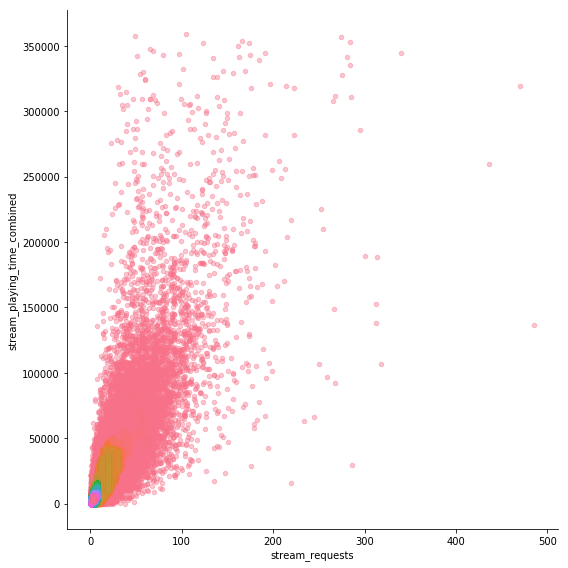

In [18]:
%matplotlib inline
_=clustered_scatterplot(sample,25)